# TASK 2
### Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline 
#импортируем библиотеки

In [2]:
df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/12gk_ATEeBZm4A', sep=';') #читаем данные с Яндекс Диска

Смотрим на датасет (типы данных, пропущенные значения, повторения user_id, верные ли данные передали по группам ("ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667"))

In [3]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [4]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [5]:
df.isnull().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [6]:
df.user_id.duplicated().sum()

0

In [7]:
df.shape

(404770, 3)

In [8]:
df.query('testgroup == "a"').shape[0] # Количество игроков в контрольной группе

202103

In [9]:
df.query('testgroup == "b"').shape[0] # Количество игроков в тестовой группе

202667

In [10]:
df.query('testgroup == "a" and revenue >0').shape[0] # Количество платящих игроков в контрольной группе

1928

In [11]:
df.query('testgroup == "b" and revenue >0' ).shape[0] # Количество платящих игроков в тестовой группе

1805

In [12]:
df.groupby('testgroup', as_index=False) \
    .agg({'revenue':'mean'}) # Считает ARPU для групп

,testgroup,revenue
0,a,25.413720
1,b,26.751287


In [13]:
round((26.751287/25.413720 - 1)*100, 2) # Проверяем разницу в ARPU, видим увеличение на 5% как и ожидалось из условия

5.26

Данные совпадают с описанными, можно приступать к анализу

In [14]:
a = df.query('testgroup == "a" and revenue > 0')
b = df.query('testgroup == "b" and revenue > 0')

Text(0.5, 1.0, 'Revenue distribution for paying users')

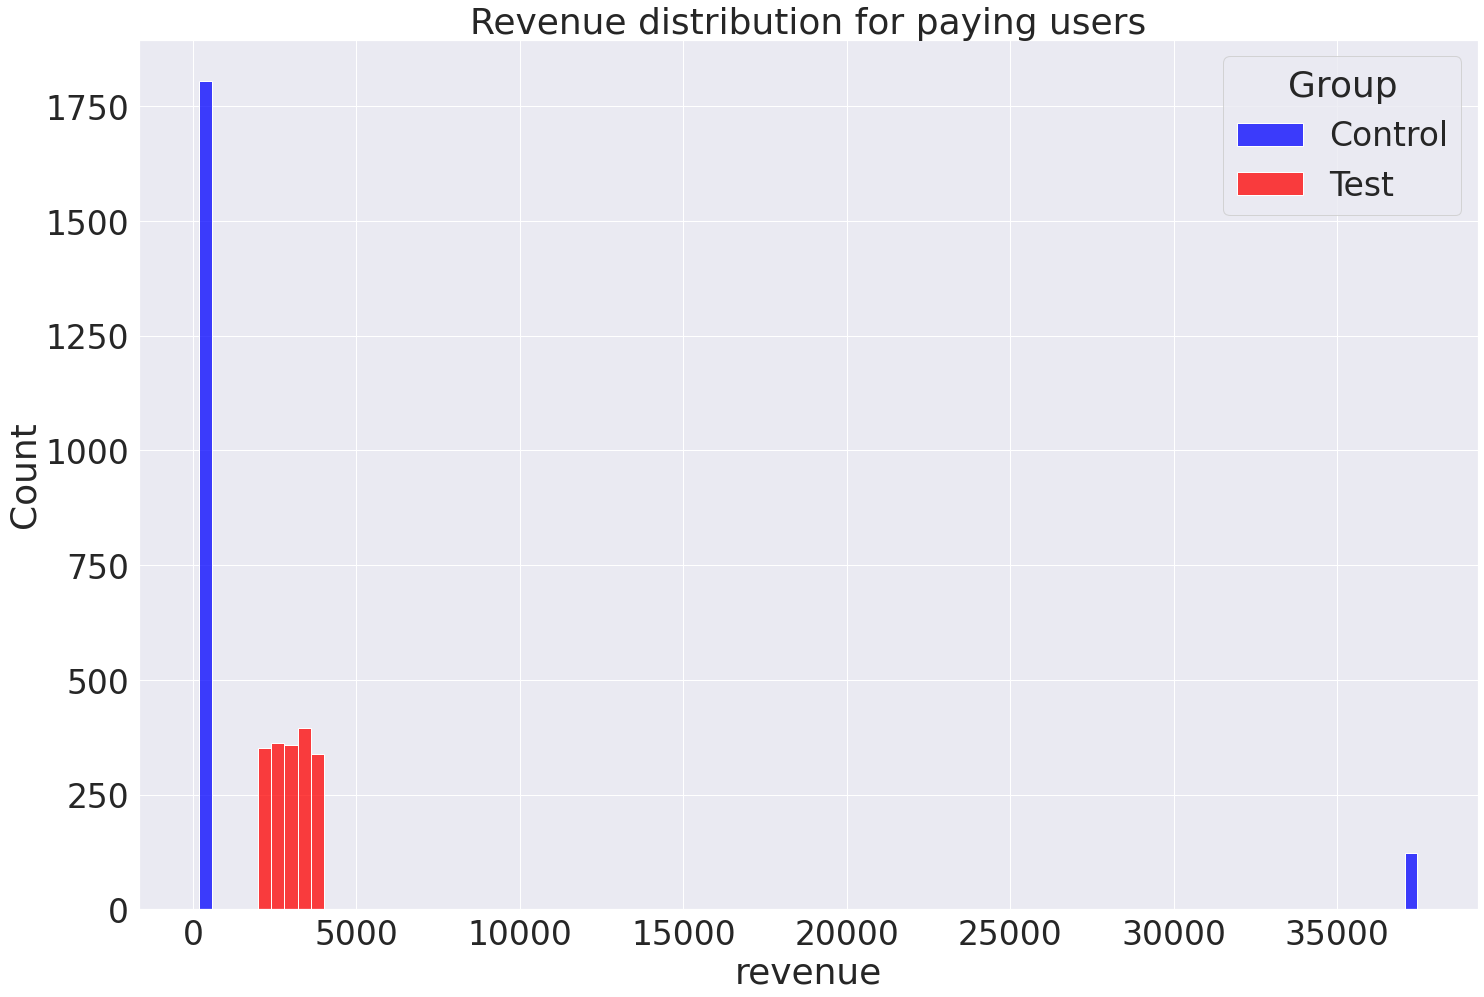

In [15]:
sns.set(rc={'figure.figsize':(24,16)})
sns.set(font_scale=3)
sns.histplot(data=a, x='revenue', color='blue', bins=100)
sns.histplot(data=b, x='revenue', color='red', bins=5) # Смотрим на распределение revenue по платящим пользователям
plt.legend(title='Group', loc='upper right', labels=['Control', 'Test'])
plt.title('Revenue distribution for paying users')

Видим очень разное поведение между контрольной и тестовой группой: в контрольной группе много людей, платящих чуть больше нуля (планктон), и небольшое количество юзеров, платящих огромные суммы (киты). В то время как в тестовой группе все платящие платят значительные суммы (дельфины), но на порядок меньшие, чем киты

Видим, что распределение как минимум контрольной группы не нормальное, так что сравнивать тест и контроль t-тестом не получится. Может помочь тест Манна-Уитни, однако если сравнивать выборки всех 200к пользователей, то 99% там совпадающие значения -- нули. Поэтому Манн-Уитни, скорее всего, не покажет нам разницу выборок

In [16]:
scipy.stats.mannwhitneyu(df[df.testgroup == "a"].revenue, df[df.testgroup == "b"].revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

pvalue=0.0627, поэтому отвергнуть нулевую гипотезу об отсутствии разницы между выборками мы не можем. Это довольно ожидаемый результат для такой выборки.
Мы можем провести тест Манна-Уитни для выборок платящих юзеров, и это даст нам подтверждение, что эти выборки отличаются

In [17]:
scipy.stats.mannwhitneyu(df[df.testgroup == "a"].query('revenue > 0').revenue,
                         df[df.testgroup == "b"].query('revenue > 0').revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

pvalue=0.0, выборки отличаются (что и так было заметно невооружённым взглядом, но всё же лучше подтвердить это числами). Однако никаких выводов здесь мы сделать не можем, Манн-Уитни плохо интерпретируется и принять решение о том, какая группа лучше мы не можем.
Тут нам на помощь может прийти бутстрап (функция честно взята из лекции по бутстрапу)

In [18]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа (квантили)
def get_bootstrap_quantile(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    qu = 0.5, # какой квантиль смотрим
    bootstrap_conf_level = 0.95 # уровень значимости
                          ):
    """Функция принимает на вход две серии, которые мы тестируем, boot_it - количество подвыборок (по дефолту 1000), 
    qu - какой квантиль смотрим (по дефолту 0.5),  bootstrap_conf_level - уровень значимости (по дефолту 0.95). На выходе 
    выдаёт данные бутстрапа, confidence interval и p-value"""
    
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(np.quantile(a = (samples_1-samples_2), q=qu)) #  - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
             
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [19]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа (среднее значение)
def get_bootstrap_mean(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    bootstrap_conf_level = 0.95 # уровень значимости
                      ):
    
    """Функция принимает на вход две серии, которые мы тестируем, boot_it - количество подвыборок (по дефолту 1000), 
    bootstrap_conf_level - уровень значимости (по дефолту 0.95). На выходе 
    выдаёт данные бутстрапа, confidence interval и p-value"""
        
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(np.mean(a = (samples_1-samples_2))) #  - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
             
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [20]:
# Объявим функцию, которая позволит визуализировать результаты бутстрапа
def bootstrap_vis(
                bootstrap_data
                 ):
    
    """Функция принимает на вход данные бутстрапа и их визуализирует"""
    
    plt.hist(bootstrap_data["boot_data"], bins = 50)
    plt.style.use('ggplot')
    plt.vlines(bootstrap_data["ci"],ymin=0,ymax=200,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    

Проведём бутстрап по всем юзерам (1000 подвыборок, так как процесс не очень быстрый)

In [21]:
mean_data_pu = get_bootstrap_mean(df[df.testgroup == "a"].revenue, 
                                  df[df.testgroup == "b"].revenue, 
                                  boot_it=1000
                                 )

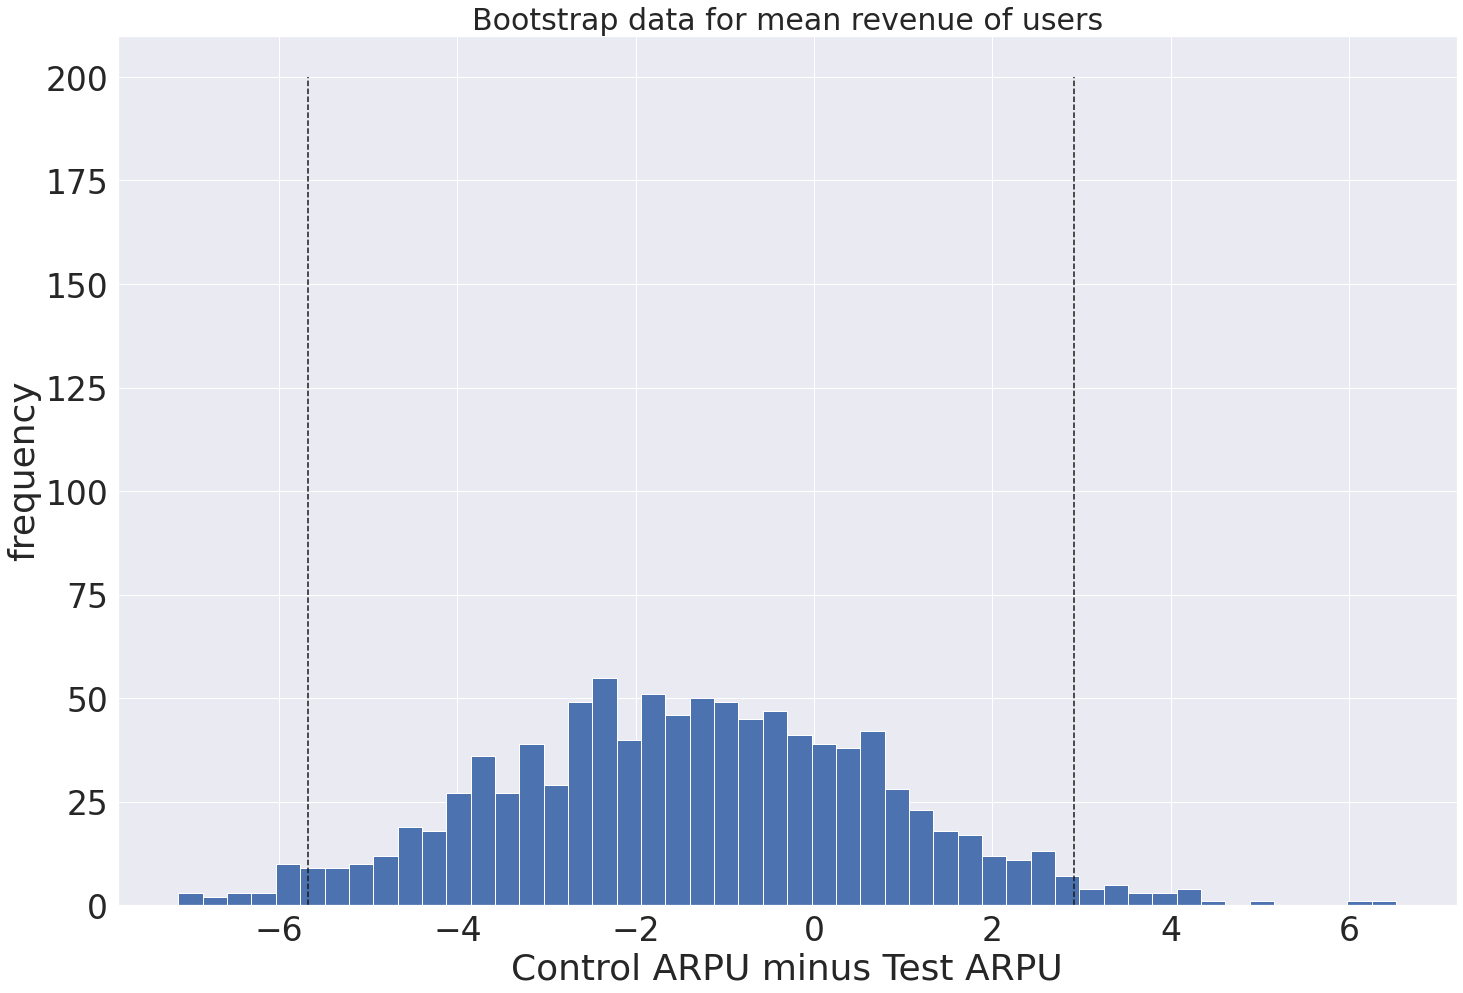

In [22]:
sns.set(font_scale=3)
bootstrap_vis(mean_data_pu)
plt.title("Bootstrap data for mean revenue of users", fontsize=30)
plt.xlabel('Control ARPU minus Test ARPU')
plt.show()


Видим, что 0 попадает в доверительный интервал, значит статистической разницы по ARPU мы не выявили

Сделаем то же самое только для платящих юзеров

In [23]:
mean_data_ppu = get_bootstrap_mean(df[df.testgroup == "a"].query('revenue > 0').revenue, 
                                   df[df.testgroup == "b"].query('revenue > 0').revenue, 
                                   boot_it = 10000
                                   ) # Делаем 10000 подвыборок, потому что можем (данных гораздо меньше, процесс быстрый)

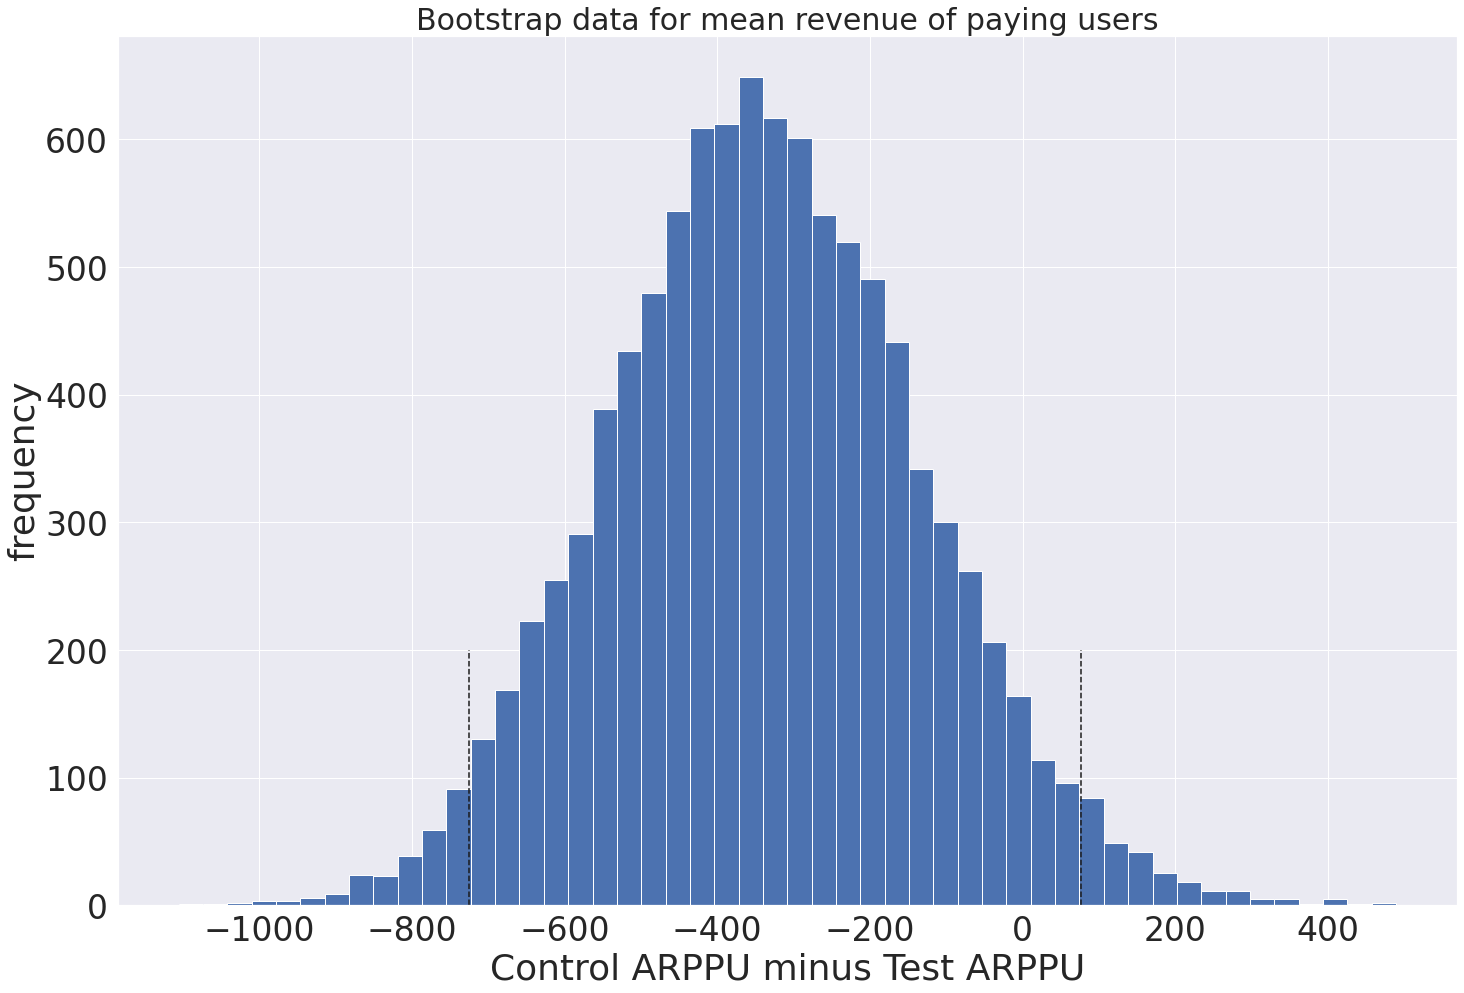

In [24]:
sns.set(font_scale=3)
bootstrap_vis(mean_data_ppu)
plt.title("Bootstrap data for mean revenue of paying users", fontsize = 30)
plt.xlabel('Control ARPPU minus Test ARPPU')
plt.show()

0 опять попадает в доверительный интервал, так что ARPPU тоже статистически значимо не отличается согласно данным бутстрапа

Получается, что по выручке разницы между наборами нет, оба набора показали себя одинаково. Однако давайте посмотрим выручку от 90% платящих пользователей

In [25]:
quantil_data_90_ppu = get_bootstrap_quantile(df[df.testgroup == "a"].query('revenue > 0').revenue, 
                                             df[df.testgroup == "b"].query('revenue > 0').revenue, 
                                             qu = 0.90,
                                             boot_it = 10000
                                             ) # Делаем 10000 подвыборок, потому что можем (данных гораздо меньше, процесс быстрый)

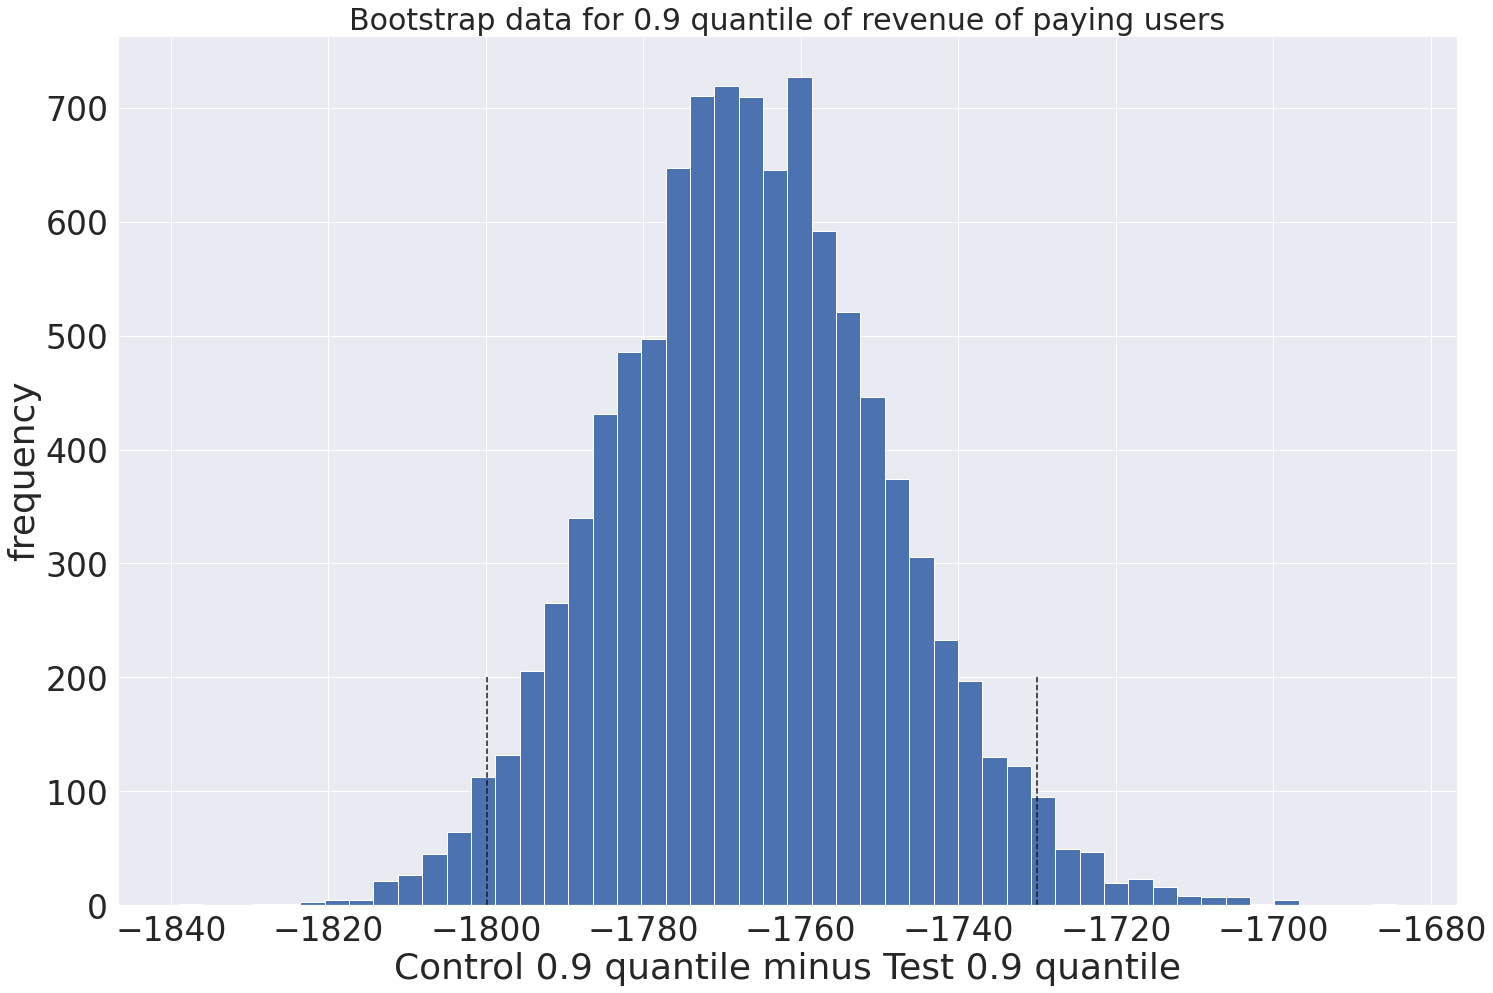

In [26]:
sns.set(font_scale=3)
bootstrap_vis(quantil_data_90_ppu)
plt.title("Bootstrap data for 0.9 quantile of revenue of paying users", fontsize = 30)
plt.xlabel('Control 0.9 quantile minus Test 0.9 quantile')
plt.show()

Мы видим, что в контрольной группе 90% пользователей платит заметно меньше, чем 90% пользователей в тестовой группе

In [27]:
round((df[df.testgroup == "a"].query('revenue > 2000').revenue.sum() /
        df[df.testgroup == "a"].query('revenue > 0').revenue.sum())*100, 1) 
# Посчитаем процент выручки китов в контрольной группе 

89.4

In [28]:
df[df.testgroup == "a"].query('revenue > 2000').user_id.count() # Посчитаем количество китов

123

Последнее, что можно проверить -- CR с помощью хи-квадрата, но в моём понимании результат получится довольно бесполезный, ведь мы не знаем из этих данных количество показов рекламы наборов, количество покупок каждым пользователем (знаем только итоговую сумму) и никаких подобных параметров, поэтому не совсем ясно какой именно CR мы здесь получим

#### Вывод: оба набора показали себя одинаково с точки зрения выручки. Однако структура платящих пользователей сильно отличается: В контрольной группе мы имеем небольшое количество китов (123 человека), которые обеспечивают почти всю выручку (89,4%), в то время как в тестовой группе у нас большое количество дельфинов (1805 человек), которые платят от 2000 до 4000.

#### Вопрос к бизнесу какой вариант для них предпочтительнее: работа с небольшим количеством китов, или с большим количеством средне платящих дельфинов. На основании этого и стоит выбрать итоговый вариант наборов предложений для игроков. Лично мне кажется тестовый вариант с большим количеством средне платящих игроков предпочтительным, поскольку в нем меньше зависимость от конкретных игроков => меньше риск потерять прибыль при отвале платящих пользователей.